In [4]:
import os
import time
import uuid #Give unique names to each object
import cv2

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [8]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read() # OpenCV reads the image in BGR format

    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg') # uuid1ame function generates a unique name for each image
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [2]:
!labelme

2024-06-12 14:22:45,046 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\Isara Liyanage\.labelmerc


### Review Dataset and Build Image Loading Function

In [5]:
import tensorflow as tf
import json # Labels are in jason format
import numpy as np
from matplotlib import pyplot as plt

#### Standard code to limit the gpu usage

In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    

In [7]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [52]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle=False)

In [53]:
images.as_numpy_iterator().next() # Checking whether the images are loaded correctly

b'data\\images\\145ea9ce-2435-11ef-9b1e-be9ffffbf19a.jpg'

In [8]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [55]:
images = images.map(load_image)

In [45]:
images.as_numpy_iterator().next()

array([[[173, 178, 172],
        [172, 177, 171],
        [173, 175, 170],
        ...,
        [116, 111, 118],
        [116, 110, 122],
        [116, 110, 122]],

       [[173, 178, 172],
        [172, 177, 171],
        [173, 175, 170],
        ...,
        [116, 111, 118],
        [116, 110, 120],
        [116, 110, 120]],

       [[175, 178, 171],
        [174, 177, 170],
        [174, 175, 169],
        ...,
        [117, 112, 119],
        [117, 112, 119],
        [116, 111, 118]],

       ...,

       [[164, 164, 166],
        [164, 164, 166],
        [164, 164, 166],
        ...,
        [137, 138, 133],
        [137, 138, 133],
        [137, 138, 133]],

       [[163, 163, 165],
        [163, 163, 165],
        [164, 164, 166],
        ...,
        [137, 138, 133],
        [136, 137, 132],
        [136, 137, 132]],

       [[163, 163, 165],
        [163, 163, 165],
        [164, 164, 166],
        ...,
        [136, 137, 132],
        [136, 137, 132],
        [136, 137, 132]]

In [56]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

#### View Raw Images

In [57]:
image_generator = images.batch(4).as_numpy_iterator()



In [60]:
plot_images = image_generator.next()

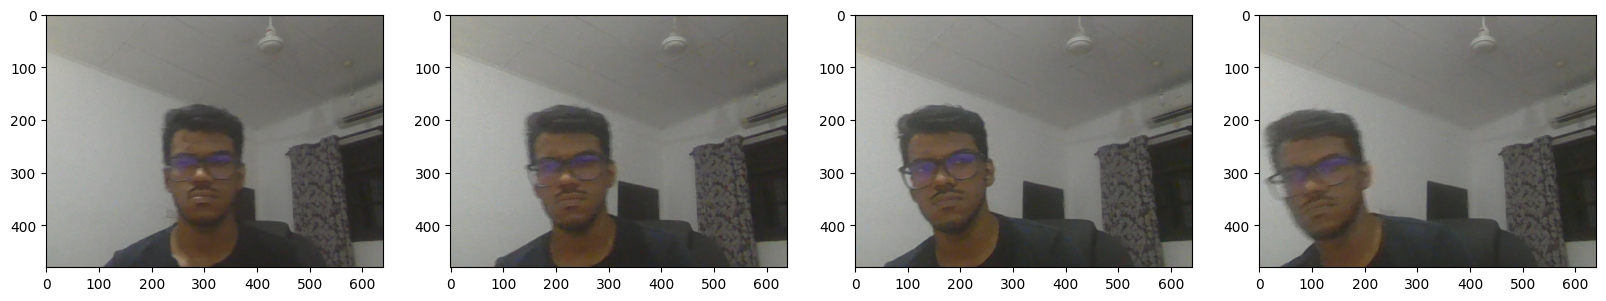

In [61]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

### Split the data


In [66]:
import os
import shutil
import random

# Paths
input_dir = 'data/images'
#output_dir = 'output'
train_dir = os.path.join('data/train', 'images')
val_dir = os.path.join('data/val', 'images')
test_dir = os.path.join('data/test', 'images')

# Create output directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List all image files
image_files = [f for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]

# Shuffle the image files
random.seed(1337)
random.shuffle(image_files)

# Calculate split indices
total_images = len(image_files)
train_split = int(0.7 * total_images)
val_split = int(0.85 * total_images)  # 0.7 + 0.15 = 0.85

# Split the images
train_files = image_files[:train_split]
val_files = image_files[train_split:val_split]
test_files = image_files[val_split:]

# Move images to respective directories
for file in train_files:
    shutil.move(os.path.join(input_dir, file), os.path.join(train_dir, file))

for file in val_files:
    shutil.move(os.path.join(input_dir, file), os.path.join(val_dir, file))

for file in test_files:
    shutil.move(os.path.join(input_dir, file), os.path.join(test_dir, file))

print(f'Total images: {total_images}')
print(f'Training images: {len(train_files)}')
print(f'Validation images: {len(val_files)}')
print(f'Testing images: {len(test_files)}')


Total images: 90
Training images: 62
Validation images: 14
Testing images: 14


### Moving the labels

In [67]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

### Image Augmentation

In [5]:
cv2.imread(os.path.join('data','train','images','1a3de05a-2435-11ef-8789-be9ffffbf19a.jpg')).shape

(480, 640, 3)

In [6]:
import albumentations as alb

In [8]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### Load Data

In [15]:
img = cv2.imread(os.path.join('data','train', 'images','17255597-2435-11ef-86ed-be9ffffbf19a.jpg'))

In [18]:
with open(os.path.join('data', 'train', 'labels', '17255597-2435-11ef-86ed-be9ffffbf19a.json'), 'r') as f:
    label = json.load(f)

In [19]:
label

{'version': '5.4.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[79.88372093023253, 147.2674418604651],
    [265.3488372093023, 398.4302325581395]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '..\\images\\17255597-2435-11ef-86ed-be9ffffbf19a.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnL

In [20]:
# Extract Coordinates and Rescale to Match Image Resolution
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1] # Coords are in format [x1, y1, x2, y2]

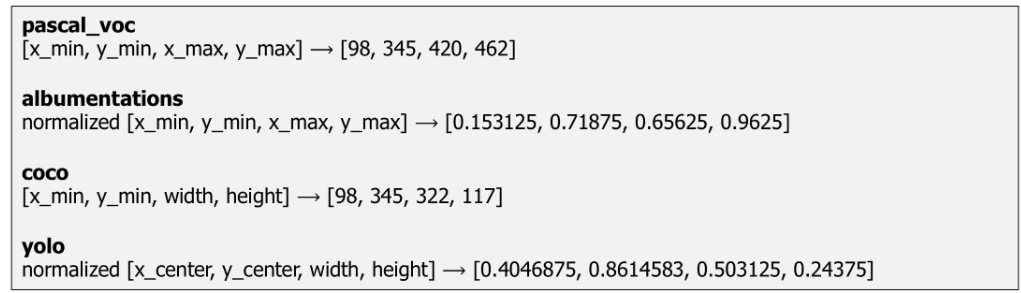

##### Usually we use pascal_voc. But since we are augmenting the images we have to standardize the bounding box. So we use 'albumentations' method

In [21]:
coords = list(np.divide(coords, [640,480,640,480])) # Original image resolution is 640x480

In [22]:
coords

[0.12481831395348833,
 0.3068071705426357,
 0.41460755813953487,
 0.8300629844961239]

In [24]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

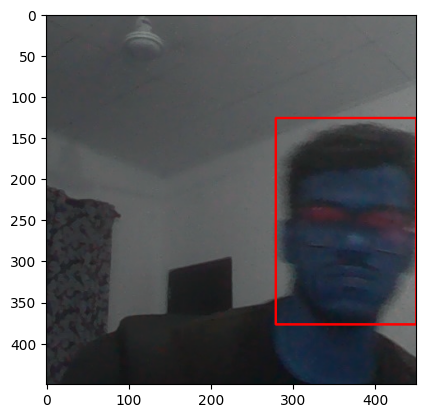

In [25]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)), # Normalized values are multiplied by new resolutions
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

### Augmentation Pipeline

In [9]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [9]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

### Prepare Labels

In [10]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [11]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

### Combine Images and Labels

In [12]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3720, 3720, 840, 840, 840, 840)

In [13]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [14]:
data_samples = train.as_numpy_iterator()

In [15]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


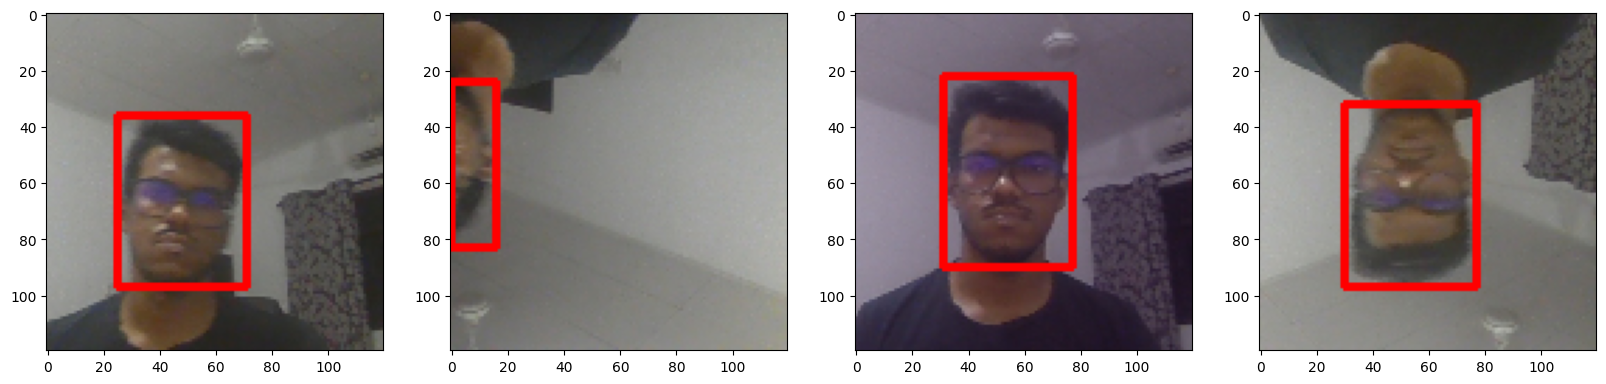

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx].copy()
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

### Functional API Deep Learning

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [19]:
vgg = VGG16(include_top=False)

In [20]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Two different models for classification and bounding box regression
    
    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [22]:
facetracker = build_model()

In [23]:
facetracker.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
X, y = train.as_numpy_iterator().next()

In [31]:
X # Has the image data as batches

array([[[[0.69914216, 0.70398283, 0.684375  ],
         [0.70226717, 0.70618874, 0.6865809 ],
         [0.702451  , 0.70637256, 0.6867647 ],
         ...,
         [0.18431373, 0.18578431, 0.17352942],
         [0.18039216, 0.18039216, 0.17254902],
         [0.18339461, 0.18339461, 0.17555147]],

        [[0.7088235 , 0.71666664, 0.7019608 ],
         [0.6936275 , 0.70098037, 0.68088233],
         [0.6940564 , 0.69797796, 0.67444855],
         ...,
         [0.17254902, 0.1764706 , 0.15637255],
         [0.18033089, 0.18425246, 0.16458334],
         [0.19117647, 0.19509804, 0.1754902 ]],

        [[0.69803923, 0.7058824 , 0.6862745 ],
         [0.7083946 , 0.7167279 , 0.6961397 ],
         [0.6867647 , 0.6906863 , 0.6671569 ],
         ...,
         [0.18333334, 0.1872549 , 0.1637255 ],
         [0.19417892, 0.19810049, 0.17457108],
         [0.19834559, 0.20226716, 0.17873774]],

        ...,

        [[0.7137255 , 0.7171569 , 0.6632353 ],
         [0.7146446 , 0.7185662 , 0.6636642 ]

In [53]:
y # 1 & 0 represents whether there is a face in the image or not and the coordinates of the face

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.47   , 0.0558 , 0.899  , 0.7017 ],
        [0.1403 , 0.1881 , 0.6353 , 0.904  ],
        [0.3672 , 0.1692 , 0.715  , 0.646  ],
        [0.1694 , 0.223  , 0.615  , 0.78   ],
        [0.1646 , 0.3406 , 0.5083 , 0.8237 ],
        [0.     , 0.07184, 0.448  , 0.679  ],
        [0.4272 , 0.2615 , 0.811  , 0.772  ],
        [0.2094 , 0.1925 , 0.61   , 0.7065 ]], dtype=float16))

### Custom Loss Function

In [25]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [31]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

c:\Users\Isara Liyanage\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [26]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [27]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### Training the model

In [28]:
## Updated Code

class FaceTracker(Model):
  def __init__(self, eyetracker, **kwargs):
    super().__init__(**kwargs)
    self.model = eyetracker

  def compile(self, opt, classloss, localizationloss, **kwargs):
    super().compile(**kwargs)
    self.closs = classloss
    self.lloss = localizationloss
    self.opt = opt

  @tf.function  # Decorate train_step with @tf.function
  def train_step(self, batch, **kwargs):
    X, y = batch

    with tf.GradientTape() as tape:
      try:
        classes, coords = self.model(X, training=True)

        # Ensure y[0] has a defined rank (handle potential reshaping)
        y_0 = tf.reshape(y[0], [-1, 1])  # Example: Reshape to (batch_size,1) if needed
        # Check your data format and reshape accordingly

        # Ensure classes has a defined rank (check model output shape)
        # ... (reshape classes if necessary based on your model's output)

        batch_classloss = self.closs(y_0, classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32),
coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss

      except tf.errors.InvalidArgumentError as e:
        # Handle the case where y[0] might have a batch size of zero(optional)
        if 'Input tensors must be of size at least 1' in str(e):
          return {"total_loss": tf.constant(0.0)}  # Dummy loss (optional)
        else:
          raise e  # Re-raise other errors

      grad = tape.gradient(total_loss, self.model.trainable_variables)
      self.opt.apply_gradients(zip(grad, self.model.trainable_variables))

    return {"total_loss": total_loss, "class_loss": batch_classloss,
"regress_loss": batch_localizationloss}

  def test_step(self, batch, **kwargs):
    X, y = batch
    classes, coords = self.model(X, training=False)

    # Ensure y[0] has a defined rank (handle potential reshaping)
    y_0 = tf.reshape(y[0], [-1, 1])  # Example: Reshape to (batch_size, 1)if needed
    # Check your data format and reshape accordingly

    # Ensure classes has a defined rank (check model output shape)
    # ... (reshape classes if necessary based on your model's output)

    batch_classloss = self.closs(y_0, classes)
    batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
    total_loss = batch_localizationloss + 0.5 * batch_classloss
    return {"total_loss": total_loss, "class_loss": batch_classloss,
"regress_loss": batch_localizationloss}

  def call(self, X, **kwargs):
    return self.model(X, **kwargs)

In [29]:
model = FaceTracker(facetracker)

In [32]:
model.compile(opt, classloss, regressloss)

In [33]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [39]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
 14/465 ━━━━━━━━━━━━━━━━━━━━ 7:21 978ms/step - class_loss: 0.4273 - regress_loss: 1.6356 - total_loss: 1.8493

KeyboardInterrupt: 

In [63]:
for images, labels in train.take(1):
    print(images.shape)
    print(labels[0].shape, labels[1].shape)

(8, 120, 120, 3)
(8, 1) (8, 4)


In [65]:
for images, labels in val.take(1):
    print(images.shape)
    print(labels[0].shape, labels[1].shape)

(8, 120, 120, 3)
(8, 1) (8, 4)


In [79]:
hist

KeyError: 'total_loss'

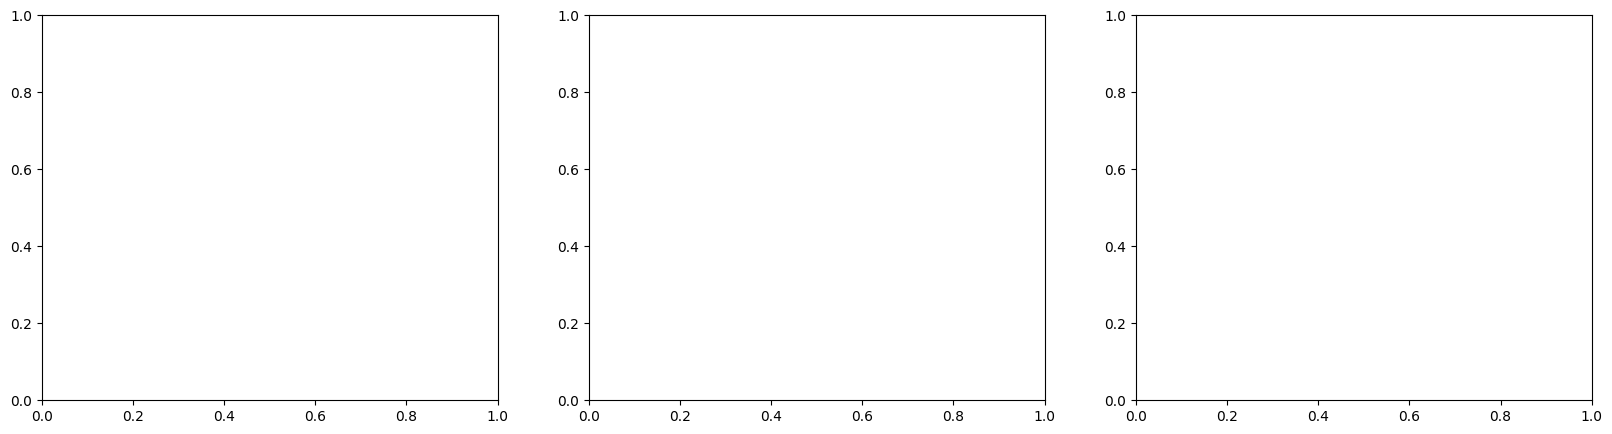

In [72]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [34]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


In [77]:
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


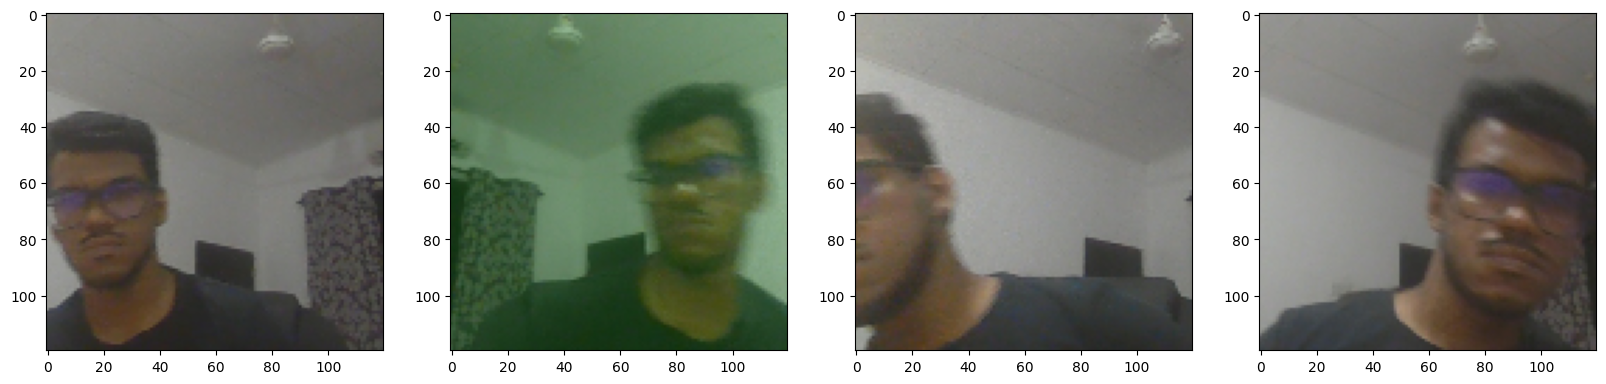

In [35]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx].copy()
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [36]:
from tensorflow.keras.models import load_model



In [37]:
facetracker.save('facetracker3.h5')

ValueError: Unable to synchronously create dataset (name already exists)

In [38]:
facetracker = load_model('facetracker.h5')

ValueError: The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(3, 3, 64, 64), Received: value.shape=(3, 3, 3, 64). Target variable: <KerasVariable shape=(3, 3, 64, 64), dtype=float32, path=block1_conv2/kernel>

In [9]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

NameError: name 'facetracker' is not defined